In [1]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

# mixed precision 설정
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# GPU 설정
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2024-07-11 05:23:12.232981: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-11 05:23:12.270391: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


In [2]:
from __future__ import division
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Conv2DTranspose, Activation, Reshape, LayerNormalization, BatchNormalization
from tensorflow.keras.layers import Embedding, multiply, Input, Dropout, Concatenate, Dense, LeakyReLU, Flatten, UpSampling2D
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model

In [3]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL_NAME = 'DCGAN & CGN'
OUTPUT_PATH = os.path.join('outputs', MODEL_NAME)
TRAIN_LOGDIR = os.path.join("logs", "tensorflow", MODEL_NAME, 'train_data') # Sets up a log directory.
if not os.path.exists(OUTPUT_PATH):
    os.makedirs(OUTPUT_PATH)
    
TARGET_IMG_SIZE = 64 

BATCH_SIZE = 32
NOISE_DIM = 100
LAMBDA = 10 # For gradient penalty

EPOCHs = 200
CURRENT_EPOCH = 1 # Epoch start from
SAVE_EVERY_N_EPOCH = 15 # Save checkpoint at every n epoch

N_CRITIC = 3 # Train critic(discriminator) n times then train generator 1 time.
LR = 1e-4
MIN_LR = 0.000001 # Minimum learning rate
DECAY_FACTOR=1.00004 # learning rate decay factor

# Creates a file writer for the log directory.
file_writer = tf.summary.create_file_writer(TRAIN_LOGDIR)

2024-07-11 05:23:14.645979: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9773 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5


In [4]:
import os
from PIL import Image

dataset_directories = [
    'eardrumDs_edit',
    'fig_eardrum',
    'Aug_image'
]

#0: normal, 1:abnormal
label_map = {
    'Normal': 0,
    'Normal_f' : 0,
    'Aom': 1,
    'Aom_f': 1,
    'Chornic': 1,
    'Chornic_f': 1,
    'PseduoMembran': 1,
    'tympanoskleros': 1
}

exclude_files = {'.DS_Store'}

image_paths = []
image_labels = []

for dataset_directory in dataset_directories:
    for label_folder in os.listdir(dataset_directory):
        if label_folder in exclude_folders or label_folder in exclude_files:  
            continue
        folder_path = os.path.join(dataset_directory, label_folder)
        
        if not os.path.isdir(folder_path):  
            continue
        
        for image_filename in os.listdir(folder_path):
            if image_filename in exclude_files:  
                continue
            full_path = os.path.join(folder_path, image_filename)
            if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
                if not image_filename.lower().endswith('.png'):
                    with Image.open(full_path) as img:
                        new_filename = os.path.splitext(image_filename)[0] + '.png'
                        new_full_path = os.path.join(folder_path, new_filename)
                        img.save(new_full_path, 'PNG')
                    os.remove(full_path)
                    full_path = new_full_path
                
                image_paths.append(full_path)
                image_labels.append(label_map[label_folder])

In [5]:
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

print('Normal:', label_0_count)
print('Abnormal:', label_1_count)

Normal: 496
Abnormal: 271


eardrumDs_edit/Normal/normal_111.png
eardrumDs_edit/Normal/normal_370.png
eardrumDs_edit/Normal/normal_72.png
eardrumDs_edit/Normal/normal_303.png
eardrumDs_edit/Normal/normal_102.png
Training data shape: (767, 64, 64, 3)


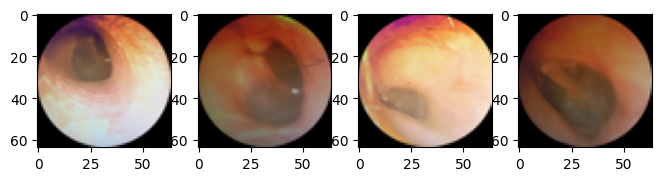

In [6]:
for f in image_paths[:5]:
    print(f)

def load_and_normalize_image(path, target_size=(128, 128)):
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    
    return image

# 모든 이미지를 로드하고 정규화하여 리스트에 추가
images = [load_and_normalize_image(path) for path in image_paths]
images = np.array(images)

train_data = images
print("Training data shape:", train_data.shape)

fig = plt.figure(figsize=(10, 10))
nplot = 5
for i in range(1, nplot):
    ax = fig.add_subplot(1, nplot, i)
    ax.imshow(train_data[i])
plt.show()

In [7]:
def CGAN_generator(input_z_shape=NOISE_DIM, num_classes=2):
    input_z_layer = Input(shape=(input_z_shape,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, input_z_shape)(label)
    label_embedding = Flatten()(label_embedding)
    
    model_input = multiply([input_z_layer, label_embedding])
    
    z = Dense(4*4*512, use_bias=False)(model_input)
    z = Reshape((4, 4, 512))(z)
    
    x = Conv2DTranspose(512, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(z)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    output = Conv2DTranspose(3, (4, 4), strides=(1, 1), padding='same', use_bias=False, activation="tanh", kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    model = Model(inputs=[input_z_layer, label], outputs=output)
    return model


In [8]:
def CGAN_discriminator(input_x_shape=(TARGET_IMG_SIZE, TARGET_IMG_SIZE, 3), num_classes=2):
    input_x_layer = Input(shape=input_x_shape)
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Embedding(num_classes, np.prod(input_x_shape))(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(input_x_shape)(label_embedding)
    
    model_input = multiply([input_x_layer, label_embedding])
    
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(model_input)
    x = LeakyReLU()(x)
    
    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(512, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1024, (4, 4), strides=(2, 2), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    x = LeakyReLU()(x)
    
    x = Conv2D(1, (4, 4), strides=(1, 1), padding='same', use_bias=False, kernel_initializer=RandomNormal(mean=0.0, stddev=0.02))(x)
    
    x = Flatten()(x)
    
    output = Dense(1)(x)
    
    model = Model(inputs=[input_x_layer, label], outputs=output)
    return model


In [9]:
# 손실 함수
def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output, gradient_penalty):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output) + LAMBDA * gradient_penalty

def gradient_penalty(real, fake, labels):
    epsilon = tf.random.uniform([real.shape[0], 1, 1, 1], 0.0, 1.0)
    x_hat = epsilon * real + (1 - epsilon) * fake
    with tf.GradientTape() as gp_tape:
        gp_tape.watch(x_hat)
        d_hat = discriminator([x_hat, labels], training=True)
    gradients = gp_tape.gradient(d_hat, x_hat)
    ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2, 3]))
    d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
    return d_regularizer

D_optimizer = Adam(learning_rate=LR, beta_1=0.5)
G_optimizer = Adam(learning_rate=LR, beta_1=0.5)

generator = CGAN_generator()
discriminator = CGAN_discriminator()

def learning_rate_decay(current_lr, decay_factor=DECAY_FACTOR):
    new_lr = max(current_lr / decay_factor, MIN_LR)
    return new_lr

def set_learning_rate(new_lr):
    K.set_value(D_optimizer.lr, new_lr)
    K.set_value(G_optimizer.lr, new_lr)

def generate_latent_vector(batch_size, noise_dim):
    return tf.random.uniform(shape=(batch_size, noise_dim), minval=-1.0, maxval=1.0)

def generate_and_save_images(model, epoch, test_input, test_labels, figure_size=(12,6), subplot=(3,6), save=True, is_flatten=False):
    predictions = model.predict([test_input, test_labels])
    if is_flatten:
        predictions = predictions.reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3).astype('float32')
    fig = plt.figure(figsize=figure_size)
    for i in range(predictions.shape[0]):
        axs = plt.subplot(subplot[0], subplot[1], i+1)
        plt.imshow(predictions[i] * 0.5 + 0.5)
        plt.axis('off')
    if save:
        plt.savefig(os.path.join(OUTPUT_PATH, 'image_at_epoch_{:04d}.png'.format(epoch)))
    plt.show()
    
num_examples_to_generate = 18

sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_labels = tf.random.uniform([num_examples_to_generate, 1], minval=0, maxval=2, dtype=tf.int32) #여기 수정 항상 해야함 

generate_and_save_images(generator, 0, sample_noise, sample_labels, figure_size=(12,6), subplot=(3,6), save=False, is_flatten=False)

2024-07-11 05:23:21.072056: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8905


1/1 [==============================] - 1s 594ms/step


ValueError: arrays must be of dtype byte, short, float32 or float64

<Figure size 1200x600 with 18 Axes>

In [11]:
# 학습 루프
@tf.function
def train_step(images, labels):
    noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])
    
    with tf.GradientTape(persistent=True) as tape:
        generated_images = generator([noise, labels], training=True)
        
        real_output = discriminator([images, labels], training=True)
        fake_output = discriminator([generated_images, labels], training=True)
        
        gp = gradient_penalty(images, generated_images, labels)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output, gp)
        
    gradients_of_generator = tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = tape.gradient(disc_loss, discriminator.trainable_variables)
    
    G_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    D_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

# 학습 루프
G_losses = []
D_losses = []
num_examples_to_generate = 1
sample_noise = tf.random.normal([num_examples_to_generate, NOISE_DIM])
sample_labels = tf.random.uniform([num_examples_to_generate], minval=0, maxval=10, dtype=tf.int32)

for epoch in range(EPOCHs):
    start = time.time()
    
    for image_batch, label_batch in train_data:
        gen_loss, disc_loss = train_step(image_batch, label_batch)
        
    # 손실 기록
    G_losses.append(gen_loss)
    D_losses.append(disc_loss)
    
    # 이미지 생성 및 저장
    generate_and_save_images(generator, epoch, [sample_noise, sample_labels])
    
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

# 손실 시각화
plt.figure(figsize=(10, 5))
plt.plot(G_losses, label='Generator Loss')
plt.plot(D_losses, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

ValueError: too many values to unpack (expected 2)